In [1]:
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:

import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict, train_test_split

 Import data

In [4]:
# User data on which prediction will be done
df_users = pd.read_hdf('../data/users.h5')

df_users['nb_of_conversation_tot'] = df_users['nb_of_conversation_as_host']+df_users['nb_of_conversation_as_guest']+df_users['nb_of_conversation_for_exchange']

# take only users that subscribed
df_subscriber = df_users[~df_users.first_subscription_date.isnull()]
df_subscriber = df_subscriber.set_index('user_id')

print(df_subscriber.isnull().sum())

df_subscriber['country']=df_subscriber['country'].fillna('unknow')
df_subscriber=df_subscriber.fillna(0)

df_subscriber['first_subscription_date'] = pd.to_datetime(df_subscriber['first_subscription_date'])
df_subscriber['last_subscription_date'] = pd.to_datetime(df_subscriber['last_subscription_date'])
df_subscriber['covid']=np.where(df_subscriber['first_subscription_date']>=pd.to_datetime('2021-04-15'), 0,1)

df_subscriber['nb_of_conversation_notFinalized_tot'] = df_subscriber['nb_of_conversation_as_host_notFinalized']+df_subscriber['nb_of_conversation_as_guest_notFinalized']+df_subscriber['nb_of_conversation_for_exchange_notFinalized']

first_subscription_date                             0
last_subscription_date                              0
nb_of_inscription                                   0
mean_churn_rate                                     0
referall                                            0
promotion                                           0
country                                            83
nb_of_conversation_as_host                          0
nb_of_conversation_as_host_notFinalized             0
nb_of_exchange_as_host_done                         0
first_date_exchange_as_host_done                20315
nb_of_exchange_as_host_canceled                     0
nb_of_conversation_as_guest                      3090
nb_of_conversation_as_guest_notFinalized         3090
nb_of_exchange_as_guest_done                     3090
first_date_exchange_as_guest_done               15034
nb_of_exchange_as_guest_canceled                 3090
nb_of_conversation_for_exchange                     0
nb_of_conversation_for_excha

In [5]:

def data_normalization(dataset, target_name='lost', sample_size=20000):
    features = ['covid', 'nb_of_inscription', # 'promotion',
                'country', # 'nb_of_conversation_notFinalized_tot',
                'nb_of_conversation_tot','nb_of_exchange_as_host_done', 'nb_of_exchange_as_guest_done',
                'nb_of_exchange_as_exchange_done']

    dataset['target']=dataset[target_name]
    
    columns=features + ['target']
    print(columns)
    dataset=dataset[columns]
    dataset = pd.concat([dataset[dataset['target']==0].sample(sample_size,random_state=42 ),
                         dataset[dataset['target']==1].sample(sample_size, random_state=42)])

    return dataset

# Definition and model

HomeExchange experiences some user churn. Several parameters were studied in the notebook : AnalysisChurn, such as the number of exchanges a user made, the use of promotions, and the number of registrations in the past three years (2019, 2020, and 2021). Since it is an annual subscription, the maximum number of subscriptions in the past three years is three.

A churner is defined as a user who decides, upon subscription renewal (after one year), whether to resubscribe or not.

Therefore, since a user can subscribe multiple times and decide to leave or not leave multiple times, the mean churn rate is calculated per user. It can be 1 (leaves after each subscription), 0 (never leaves), 0.33 (leaves once out of three subscriptions), 0.5 (leaves once out of two subscriptions), or 0.66 (leaves twice out of three subscriptions).

In this notebook, we will attempt to predict which users have the highest probability of being churners.



Two cases : 
- either the user is a churner, meaning the user didn't re-subscribed at least once in the 3 years (Churner prediction) 
- either the user is lost, meaning that the user do not re-subscribed after EACH subscription

**Model will be evulated thanks to Recall**

Recall is a performance metric that measures the ability of a model to correctly identify the true positive rate.

Recall is calculated as the ratio of true positives (TP) to the sum of true positives and false negatives (FN):

Recall = TP / (TP + FN)

In the context of binary classification, true positives (TP) represent the instances that are actually positive and correctly predicted as positive by the model. False negatives (FN) represent the instances that are actually positive but incorrectly predicted as negative by the model.

The recall metric focuses on the completeness of the model's predictions. It tells us the proportion of actual positive instances that were correctly identified as positive by the model. A higher recall value indicates that the model is better at capturing positive instances and minimizing false negatives, which means it has a lower chance of missing relevant churner.

Recall is particularly important in scenarios where the aim is to minimize the number of missed positive cases, even if it leads to a higher number of false positives.

In [6]:
df_subscriber['churner'] = np.where((df_subscriber['mean_churn_rate']>0),1, 0)
df_subscriber['lost'] = np.where((df_subscriber['mean_churn_rate']==1), 1, 0)

In [7]:
print(df_subscriber['churner'].value_counts())
print(df_subscriber['lost'].value_counts())

0    38126
1    29798
Name: churner, dtype: int64
0    45891
1    22033
Name: lost, dtype: int64


In [8]:
print(round(np.mean(df_subscriber['churner']),2)*100,'% of churner')
print(round(np.mean(df_subscriber['lost']),2)*100,'% of lost user')

44.0 % of churner
32.0 % of lost user


#  Pycaret

## Churner 

In [9]:
from pycaret.classification import *

In [10]:

target_name='churner'
dataset = data_normalization(df_subscriber, target_name=target_name, sample_size=20000)
exp = setup(data=dataset, target = 'target', 
            normalize=True, fold=10)


['covid', 'nb_of_inscription', 'country', 'nb_of_conversation_tot', 'nb_of_exchange_as_host_done', 'nb_of_exchange_as_guest_done', 'nb_of_exchange_as_exchange_done', 'target']


,Description,Value
0,Session id,724
1,Target,target
2,Target type,Binary
3,Original data shape,"(40000, 8)"
4,Transformed data shape,"(40000, 8)"
5,Transformed train set shape,"(28000, 8)"
6,Transformed test set shape,"(12000, 8)"
7,Numeric features,6
8,Categorical features,1
9,Preprocess,True


In [11]:
best =  exp.compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.6557,0.7099,0.6456,0.6588,0.6521,0.3114,0.3115,0.8490
lightgbm,Light Gradient Boosting Machine,0.6541,0.7070,0.6446,0.6571,0.6507,0.3083,0.3084,0.3880
ada,Ada Boost Classifier,0.6513,0.6997,0.6581,0.6493,0.6536,0.3026,0.3027,0.4100
xgboost,Extreme Gradient Boosting,0.6493,0.6976,0.6494,0.6492,0.6492,0.2986,0.2986,0.7160
lr,Logistic Regression,0.6339,0.6836,0.7300,0.6123,0.6660,0.2679,0.2730,0.6130
lda,Linear Discriminant Analysis,0.6289,0.6796,0.7294,0.6073,0.6628,0.2579,0.2633,0.2780
nb,Naive Bayes,0.5991,0.6782,0.8501,0.5660,0.6795,0.1982,0.2293,0.1380
qda,Quadratic Discriminant Analysis,0.5982,0.6743,0.8356,0.5666,0.6752,0.1964,0.2233,0.1390
knn,K Neighbors Classifier,0.6130,0.6436,0.6186,0.6117,0.6151,0.2260,0.2260,0.2370
rf,Random Forest Classifier,0.6089,0.6427,0.5795,0.6158,0.5970,0.2177,0.2181,1.0930


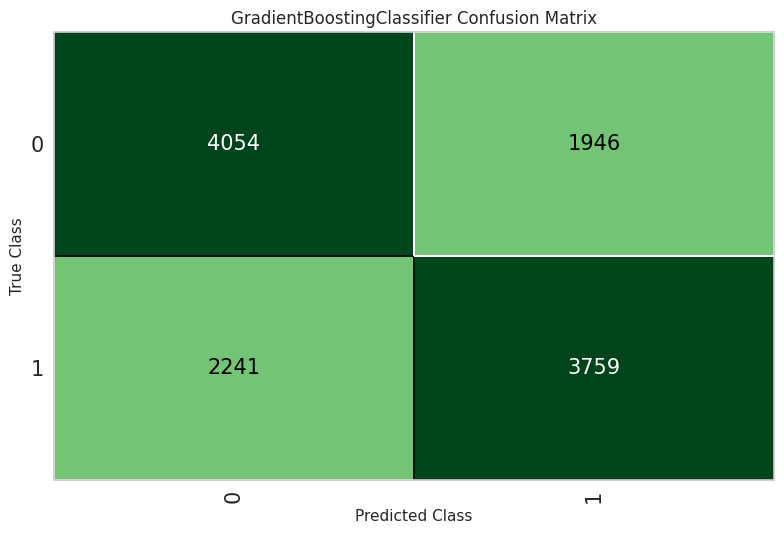

In [12]:
plot_model(best, plot='confusion_matrix')

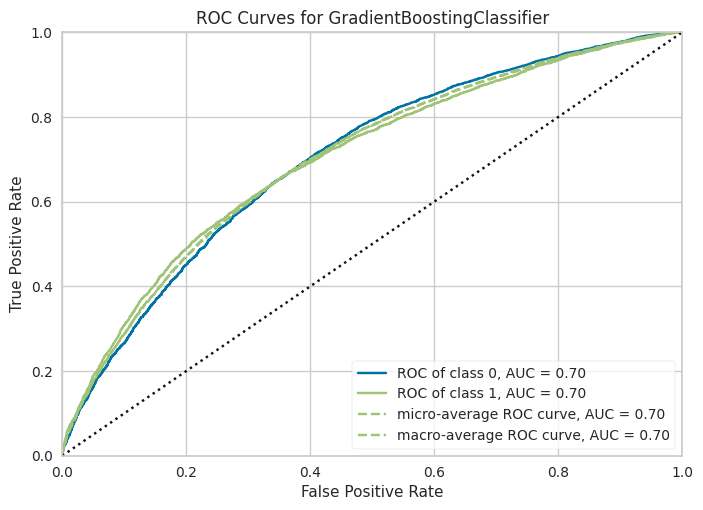

In [13]:
plot_model(best, plot='auc')

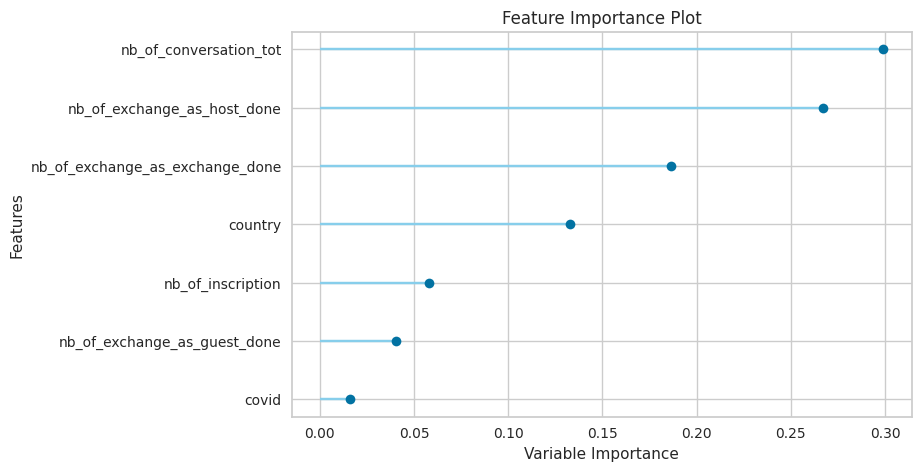

In [14]:
plot_model(best, plot='feature')

In [15]:
tuned = tune_model(best)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6561,0.7034,0.6607,0.6546,0.6577,0.3121,0.3122
1,0.6764,0.7232,0.6657,0.6803,0.6729,0.3529,0.3529
2,0.6732,0.7223,0.6736,0.6731,0.6733,0.3464,0.3464
3,0.6600,0.7156,0.6429,0.6657,0.6541,0.3200,0.3202
4,0.6529,0.7089,0.6329,0.6592,0.6458,0.3057,0.3060
5,0.6404,0.6883,0.6214,0.6459,0.6334,0.2807,0.2809
6,0.6621,0.7072,0.6371,0.6707,0.6535,0.3243,0.3247
7,0.6457,0.6921,0.6207,0.6534,0.6366,0.2914,0.2918
8,0.6450,0.7002,0.6400,0.6465,0.6432,0.2900,0.2900


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [16]:
model_churner = create_model(tuned)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6561,0.7034,0.6607,0.6546,0.6577,0.3121,0.3122
1,0.6764,0.7232,0.6657,0.6803,0.6729,0.3529,0.3529
2,0.6732,0.7223,0.6736,0.6731,0.6733,0.3464,0.3464
3,0.6600,0.7156,0.6429,0.6657,0.6541,0.3200,0.3202
4,0.6529,0.7089,0.6329,0.6592,0.6458,0.3057,0.3060
5,0.6404,0.6883,0.6214,0.6459,0.6334,0.2807,0.2809
6,0.6621,0.7072,0.6371,0.6707,0.6535,0.3243,0.3247
7,0.6457,0.6921,0.6207,0.6534,0.6366,0.2914,0.2918
8,0.6450,0.7002,0.6400,0.6465,0.6432,0.2900,0.2900


## Lost User

In [17]:
target_name='lost'
dataset = data_normalization(df_subscriber, target_name=target_name, sample_size=20000)
exp = setup(data=dataset, target = 'target', 
            normalize=True, fold=10)


['covid', 'nb_of_inscription', 'country', 'nb_of_conversation_tot', 'nb_of_exchange_as_host_done', 'nb_of_exchange_as_guest_done', 'nb_of_exchange_as_exchange_done', 'target']


,Description,Value
0,Session id,916
1,Target,target
2,Target type,Binary
3,Original data shape,"(40000, 8)"
4,Transformed data shape,"(40000, 8)"
5,Transformed train set shape,"(28000, 8)"
6,Transformed test set shape,"(12000, 8)"
7,Numeric features,6
8,Categorical features,1
9,Preprocess,True


In [18]:
best =  exp.compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7571,0.8282,0.7896,0.7415,0.7647,0.5143,0.5155,1.1070
lightgbm,Light Gradient Boosting Machine,0.7560,0.8266,0.7837,0.7426,0.7625,0.5120,0.5129,0.2370
ada,Ada Boost Classifier,0.7510,0.8232,0.8277,0.7176,0.7687,0.5019,0.5081,0.4460
xgboost,Extreme Gradient Boosting,0.7497,0.8197,0.7829,0.7342,0.7577,0.4994,0.5006,0.8070
lr,Logistic Regression,0.7452,0.8152,0.8685,0.6969,0.7732,0.4905,0.5062,0.1840
lda,Linear Discriminant Analysis,0.7358,0.8122,0.8951,0.6789,0.7721,0.4715,0.4975,0.2140
qda,Quadratic Discriminant Analysis,0.7339,0.7983,0.8706,0.6837,0.7659,0.4677,0.4863,0.2500
nb,Naive Bayes,0.7365,0.7956,0.8723,0.6861,0.7680,0.4731,0.4916,0.1970
rf,Random Forest Classifier,0.7160,0.7846,0.7113,0.7181,0.7146,0.4320,0.4321,1.4960
knn,K Neighbors Classifier,0.7214,0.7768,0.7434,0.7120,0.7274,0.4427,0.4432,0.3320


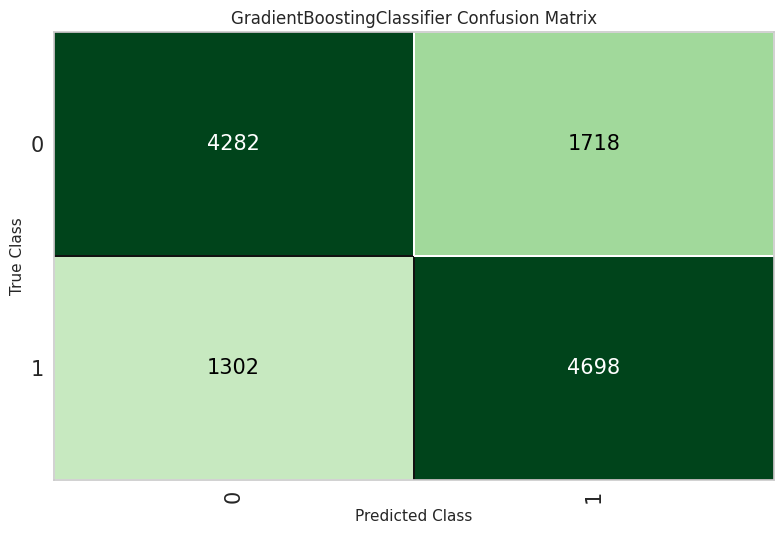

In [19]:
plot_model(best, plot='confusion_matrix')


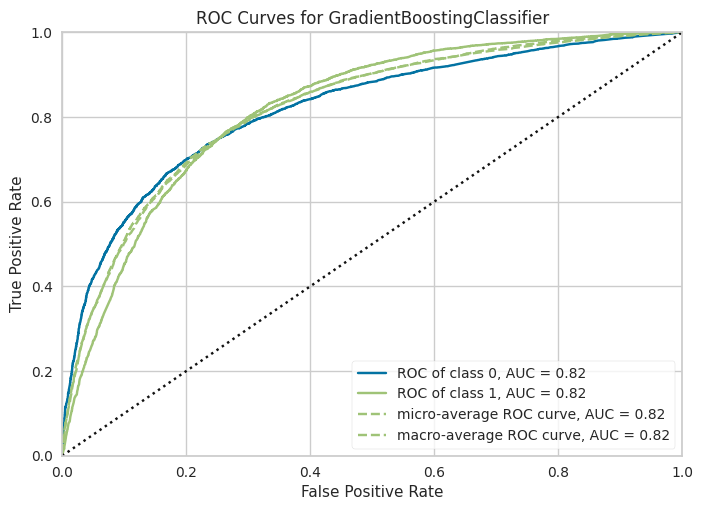

In [20]:
plot_model(best, plot='auc')

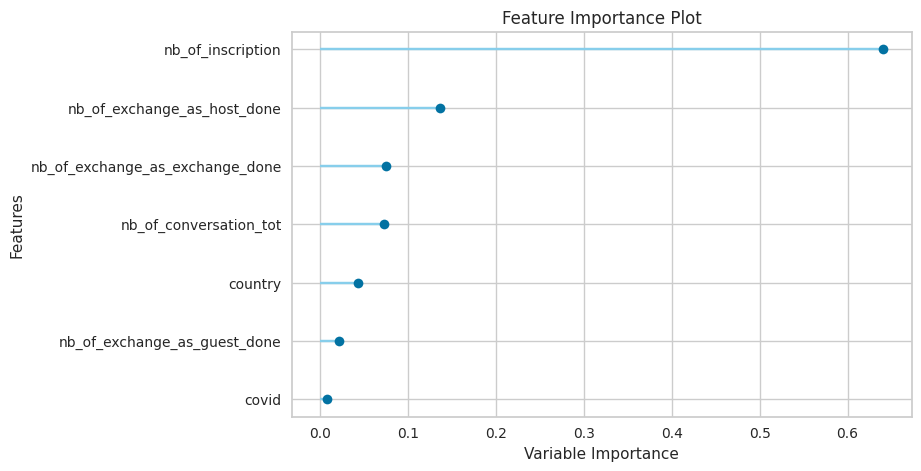

In [21]:
plot_model(best, plot='feature')

In [22]:
tuned = tune_model(best)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7557,0.8348,0.8043,0.7331,0.7670,0.5114,0.5139
1,0.7586,0.8331,0.7921,0.7423,0.7664,0.5171,0.5183
2,0.7425,0.8250,0.7757,0.7274,0.7508,0.4850,0.4861
3,0.7611,0.8266,0.8014,0.7416,0.7703,0.5221,0.5239
4,0.7614,0.8274,0.8057,0.7402,0.7715,0.5229,0.5249
5,0.7454,0.8111,0.7950,0.7232,0.7574,0.4907,0.4932
6,0.7600,0.8256,0.8007,0.7404,0.7694,0.5200,0.5217
7,0.7657,0.8373,0.8036,0.7470,0.7743,0.5314,0.5330
8,0.7454,0.8173,0.7671,0.7351,0.7508,0.4907,0.4912


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [23]:
model = create_model(tuned)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7557,0.8365,0.7936,0.7377,0.7646,0.5114,0.5129
1,0.7564,0.8354,0.7821,0.7439,0.7625,0.5129,0.5135
2,0.7471,0.8249,0.7707,0.7360,0.7530,0.4943,0.4948
3,0.7621,0.8274,0.7936,0.7466,0.7694,0.5243,0.5253
4,0.7632,0.8287,0.8021,0.7442,0.7721,0.5264,0.5280
5,0.7518,0.8131,0.7979,0.7305,0.7627,0.5036,0.5057
6,0.7604,0.8287,0.7914,0.7451,0.7676,0.5207,0.5217
7,0.7654,0.8390,0.7971,0.7495,0.7726,0.5307,0.5318
8,0.7475,0.8188,0.7614,0.7408,0.7510,0.4950,0.4952
